<a href="https://colab.research.google.com/github/FAtheme/ML-Fall2023/blob/main/ALEXNET_for_CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
import numpy as np
from tensorflow.keras import regularizers
import math
import tensorflow as tf
import tensorflow.keras.layers as tfl
from keras import backend as K

## Loading Data

In [ ]:
from tensorflow.keras.datasets import cifar100

(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='coarse')

In [ ]:
print(X_train.shape,y_train.shape)

(50000, 32, 32, 3) (50000, 1)



## Resizing images

In [ ]:
import cv2
X_train = np.array([cv2.resize(img, (140, 140)) for img in X_train])
X_test = np.array([cv2.resize(img, (140, 140)) for img in X_test])

## Encoding labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y_train=enc.fit_transform(y_train).toarray().astype(int)
y_test=enc.transform(y_test).toarray().astype(int)


print(y_train.shape)
print(y_train[0])

(50000, 20)
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]



## Data Augmentation

In [ ]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tfl.RandomFlip('horizontal'))
    data_augmentation.add(tfl.RandomRotation(0.2))

    return data_augmentation

In [ ]:
data_augmentation = data_augmenter()

## AlexNet architecture

In [ ]:
def arch(input_shape, data_augmentation):

    input_img = tf.keras.Input(shape=input_shape)
    layer = data_augmenter()(input_img)
    layer=tfl.Conv2D(filters= 96 , kernel_size= 11,strides=(4, 4))(layer)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(layer)
    layer=tfl.BatchNormalization()(layer,training=True)

    layer=tfl.Conv2D(filters= 256 , kernel_size= 5 ,strides=(1, 1), padding='same')(layer)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same')(layer)
    layer=tfl.BatchNormalization()(layer,training=True)

    layer=tfl.Conv2D(filters= 384 , kernel_size= 3 ,strides=(1, 1), padding='same')(layer)
    layer=tfl.ReLU()(layer)
    layer=tfl.Conv2D(filters= 384 , kernel_size= 3 ,strides=(1, 1), padding='same')(layer)
    layer=tfl.ReLU()(layer)
    layer=tfl.Conv2D(filters= 256 , kernel_size= 3 ,strides=(1, 1), padding='same')(layer)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same')(layer)
    layer=tfl.BatchNormalization()(layer,training=True)

    layer=tfl.Flatten()(layer)

    layer=tfl.Dense(units=4096, activation='relu')(layer)
    layer=tfl.Dropout(0.2)(layer)
    layer=tfl.BatchNormalization()(layer,training=True)

    layer=tfl.Dense(units=4096, activation='relu')(layer)
    layer=tfl.Dropout(0.2)(layer)
    layer=tfl.BatchNormalization()(layer,training=True)

    layer=tfl.Dense(units=1000, activation='relu')(layer)
    layer=tfl.Dropout(0.2)(layer)
    layer=tfl.BatchNormalization()(layer,training=True)

    outputs=tfl.Dense(units= 20 , activation='softmax')(layer)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

## training and evaluating the model

In [ ]:
conv_model = arch((140, 140, 3),data_augmentation)
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140, 140, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 140, 140, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 33, 33, 96)        34944     
                                                                 
 re_lu (ReLU)                (None, 33, 33, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 17, 17, 96)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 17, 17, 96)        384       
 Normalization)                                              

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)
history = conv_model.fit(train_dataset,epochs=20,validation_data=test_dataset,batch_size=64,shuffle=True)

Epoch 1/20
782/782 [==============================] - 55s 53ms/step - loss: 2.7354 - accuracy: 0.1944 - val_loss: 2.4201 - val_accuracy: 0.2684
Epoch 2/20
782/782 [==============================] - 42s 54ms/step - loss: 2.3540 - accuracy: 0.2821 - val_loss: 2.2174 - val_accuracy: 0.3379
Epoch 3/20
782/782 [==============================] - 42s 54ms/step - loss: 2.1570 - accuracy: 0.3381 - val_loss: 2.0379 - val_accuracy: 0.3933
Epoch 4/20
782/782 [==============================] - 42s 54ms/step - loss: 2.0042 - accuracy: 0.3815 - val_loss: 1.9140 - val_accuracy: 0.4184
Epoch 5/20
782/782 [==============================] - 43s 54ms/step - loss: 1.8731 - accuracy: 0.4170 - val_loss: 1.8094 - val_accuracy: 0.4509
Epoch 6/20
782/782 [==============================] - 43s 54ms/step - loss: 1.7656 - accuracy: 0.4492 - val_loss: 1.7131 - val_accuracy: 0.4786
Epoch 7/20
782/782 [==============================] - 43s 55ms/step - loss: 1.6791 - accuracy: 0.4741 - val_loss: 1.6659 - val_accuracy:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set the path to the folder where you want to save the checkpoint
checkpoint_path = "/content/drive/MyDrive/Colab_Checkpoints/alexnet_cifar100.ckpt"

In [ ]:
# Save the model's weights and optimizer state
conv_model.save_weights(checkpoint_path)

## Models' performance

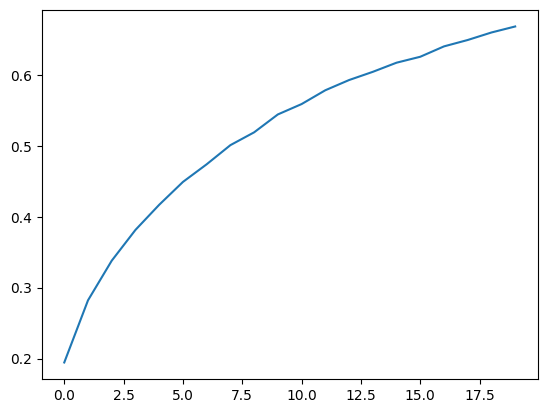

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["accuracy"])